<a href="https://colab.research.google.com/github/npanti/pubmed_classifier/blob/main/TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**
Téléchargement du dataset et chargements des packages python



In [7]:

!git clone https://github.com/aneuraz/intro-keras.git

%tensorflow_version 2.x
import json 
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Fonction 
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)

fatal: destination path 'intro-keras' already exists and is not an empty directory.


Préparation des données et des variables de training et validation

Les données sont structurées de la sorte:


```
{'Cat_2013': 'C',
 'Cat_2014': 'C',
 'Cat_2015': 'C',
 'Cat_2016': 'C',
 'Cat_2017': 'B',
 'Disciplines': ['XQ'],
 'ESSN': '1873-3557',
 'IF_2013': '2.129',
 'IF_2014': '2.353',
 'IF_2015': '2.653',
 'IF_2016': '2.536',
 'IF_2017': '2.88',
 'ISSN': '1386-1425',
 'ISSN_online': '1873-3557',
 'ISSN_print': '1386-1425',
 'IsoAbbr': 'Spectrochim Acta A Mol Biomol Spectrosc',
 'JrId': 20555,
 'MedAbbr': 'Spectrochim Acta A Mol Biomol Spectrosc',
 'NLMid': '9602533',
 'Titre': 'Spectrochim Acta A Mol Biomol Spectrosc',
 'abstract': 'In this research, ZnO nanoparticle loaded on activated carbon (ZnO-NPs-AC) was synthesized simply by a low cost and nontoxic procedure. The characterization and identification have been completed by different techniques such as SEM and XRD analysis. A three layer artificial neural network (ANN) model is applicable for accurate prediction of dye removal percentage from aqueous solution by ZnO-NRs-AC following conduction of 270 experimental data. The network was trained using the obtained experimental data at optimum pH with different ZnO-NRs-AC amount (0.005-0.015 g) and 5-40 mg/L of sunset yellow dye over contact time of 0.5-30 min. The ANN model was applied for prediction of the removal percentage of present systems with Levenberg-Marquardt algorithm (LMA), a linear transfer function (purelin) at output layer and a tangent sigmoid transfer function (tansig) in the hidden layer with 6 neurons. The minimum mean squared error (MSE) of 0.0008 and coefficient of determination (R(2)) of 0.998 were found for prediction and modeling of SY removal. The influence of parameters including adsorbent amount, initial dye concentration, pH and contact time on sunset yellow (SY) removal percentage were investigated and optimal experimental conditions were ascertained. Optimal conditions were set as follows: pH, 2.0; 10 min contact time; an adsorbent dose of 0.015 g. Equilibrium data fitted truly with the Langmuir model with maximum adsorption capacity of 142.85 mg/g for 0.005 g adsorbent. The adsorption of sunset yellow followed the pseudo-second-order rate equation.',
 'authors': ['Maghsoudi, M',
  'Ghaedi, M',
  'Zinali, A',
  'Ghaedi, A M',
  'Habibi, M H'],
 'categories': ['SPECTROSCOPY'],
 'journal': 'Spectrochimica acta. Part A, Molecular and biomolecular spectroscopy',
 'keywords': ['Adsorption',
  'Algorithms',
  'Azo Compounds',
  'Charcoal',
  'Coloring Agents',
  'Hydrogen-Ion Concentration',
  'Kinetics',
  'Microscopy, Electron, Scanning',
  'Nanotubes',
  'Neural Networks (Computer)',
  'Time Factors',
  'Water Pollutants, Chemical',
  'X-Ray Diffraction',
  'Zinc Oxide'],
 'pmid': '24995412',
 'title': 'Artificial neural network (ANN) method for modeling of sunset yellow dye adsorption using zinc oxide nanorods loaded on activated carbon: Kinetic and isotherm study.',
 'year': '2015'}
```



In [8]:
with open('/content/intro-keras/ai_pub_samp.json','r') as f:
  data = json.load(f)

# Chargement des titres et des abstract et transformation du texte en miniscule
X_title = [ x['title'].lower() for x in data ] 
X_abstract = [ x['abstract'].lower() for x in data ] 

# Calcul des longeurs max
max_len_title = len(max(X_title, key=len))
max_len_abstract = len(max(X_abstract, key=len))

# Chargmeent des catégories SIGAPS (QUESTION: on travaille sur quelle année?)
Y = [ y['categories'] for y in data ]

Distribution des catégories
On remarque qu'il y a quelques données qui n'ont pas de catégorie assignée. Il faut les retirer des données. Ces entrées ne serve à rien et vont générer de la confusion pour le réseau neuronal.

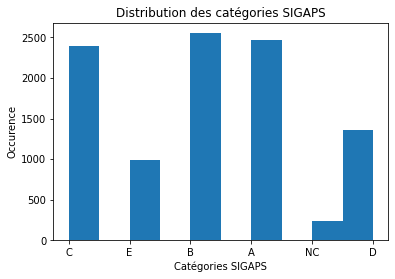

In [9]:
plt.hist(Y)
plt.title('Distribution des catégories SIGAPS')
plt.xlabel('Catégories SIGAPS')
plt.ylabel('Occurence')
plt.show()

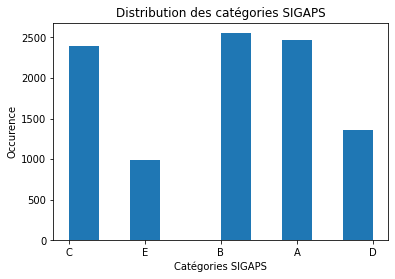

In [10]:
# Suppression des données sans catégorie
id_nc = [i for i, x in enumerate(Y) if x == "NC"]

# La liste est parcourue en sens inverse car si ce n'est pas le cas, l'ordre des données n'est pas préservée.
for i in reversed(id_nc):
  del X_title[i]
  del X_abstract[i]
  del Y[i]

#Vérifiction 
plt.hist(Y, align='mid')
plt.title('Distribution des catégories SIGAPS')
plt.xlabel('Catégories SIGAPS')
plt.ylabel('Occurence')
plt.show()

Diviser les données en set de training, validation et test. Dans ce cas, le set de validation est le même que le set de test.
Il y a deux techniques: soit on fait le split soit même ou on le fait aléatoirement avec scikit-learn

In [11]:
# Creation d'un array 2D avec les titres et les abstract (10000x2). Première pour les titres, deuxième pour les abstract.
# Cette solution permet de faire le data splitting plus facilement
X = np.column_stack((X_title, X_abstract)) 

# Split des données
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 21)

# Séparation des données
X_title_train = X_train[:,0]
X_abstract_train = X_train[:,1]
X_title_test = X_test[:,0]
X_abstract_test = X_test[:,1]

In [12]:
# Transformer les catégories en numéro
cat_to_id = {'<UNK>':0}

for cat in Y_train: 
  if cat not in cat_to_id.keys(): 
    cat_to_id[cat] = len(cat_to_id)

id_to_cat = { v: k for k,v in cat_to_id.items()}
# Calcule le nombre de catégories
num_cat = len(cat_to_id)

def preprocess_Y(Y, cat_to_id): 
  """returns list of cat_ids for Y
  """
  res = []
  for ex in Y: 
    if ex not in cat_to_id.keys(): 
      res.append(cat_to_id['<UNK>'])
    else:
      res.append(cat_to_id[ex])
  return np.array(res)

Y_train_id = preprocess_Y(Y_train, cat_to_id)
Y_test_id = preprocess_Y(Y_test, cat_to_id)

# Neural Network
On commence par spécifier les paramètres

In [69]:
vocab_size = 10000
use_glove = False
embedd_model = 'glove.6B.100d.txt'
embedd_dim = 300

#CNN
filters = [128, 128]
kernel_size = [2, 3]
max_pool = [5, 5]
dropout_conv = [0.5, 0.5]

#Dense
size = [1024, 512]
dropout_dense = [0.5, 0.5]


### **Tokenization des entrées**
Soit on utilise Tokenizer de Keras ou alors on utilise Glove

In [15]:
if not use_glove:
  tokenizer_title = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size)
  tokenizer_abstract = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size)
  # Entrainer le tokenizer sur le train set 
  tokenizer_title.fit_on_texts(X_title_train)
  tokenizer_abstract.fit_on_texts(X_abstract_train)

  # Transformer les textes en vecteurs numeriques à l'aide du tokenizer
  X_title_train_seq = tokenizer_title.texts_to_sequences(X_title_train)
  X_title_test_seq = tokenizer_title.texts_to_sequences(X_title_test)
  X_abstract_train_seq = tokenizer_abstract.texts_to_sequences(X_abstract_train)
  X_abstract_test_seq = tokenizer_abstract.texts_to_sequences(X_abstract_test)

else:
  # Charger les embeddings à l'aide de la fonction load_glove_embeddings
  word2index, embedding_matrix = load_glove_embeddings(embedd_model, embedd_dim)
  # ecrire une fonction de tokenization custom pour preprocesser les textes
  import re 
  def custom_tokenizer(input, word2index):

    # Split words
    res = []
    for t in input:
      words = re.findall(r'\w+', t)
      index = []
      for i in words:
        if i in word2index.keys():
          index.append(word2index[i])
      res.append(index)

    return res

  # Encoder les textes avec la fonction custom
  X_title_train_seq = custom_tokenizer(X_title_train, word2index)
  X_title_test_seq = custom_tokenizer(X_title_test, word2index)
  X_abstract_train_seq = custom_tokenizer(X_abstract_train, word2index)
  X_abstract_test_seq = custom_tokenizer(X_abstract_test, word2index)

# Padding
max_len_title = max([len(x) for x in X_title_train_seq])
max_len_abstract = max([len(x) for x in X_abstract_train_seq])

X_title_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_title_train_seq, maxlen=max_len_title, truncating='post')
X_title_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_title_test_seq, maxlen=max_len_title, truncating='post')
X_abstract_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_abstract_train_seq, maxlen=max_len_abstract, truncating='post')
X_abstract_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_abstract_test_seq, maxlen=max_len_abstract, truncating='post')

## **Modèle de CNN**
Dans la première partie, on créé des functions qui vont géner les élements du réseau automatiquement

In [76]:
def create_seq_conv_layers(model, filters, kernel_size, max_pool,dropout):
  for i in range(0,len(filters)):
    model.add(tf.keras.layers.Conv1D(filters=filters[i], kernel_size=kernel_size[i], activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout[i]))
    model.add(tf.keras.layers.MaxPooling1D(max_pool[i]))

  return model

def create_parallel_conv_layers(model, filters, kernel_size, max_pool, dropout):
  conv = []
  for i in range(0,len(filters)):
    conv.append(tf.keras.Sequential([
                 tf.keras.layers.Conv1D(filters=filters[i], kernel_size=kernel_size[i], activation='relu'),
                 tf.keras.layers.Dropout(dropout[i]),
                 tf.keras.layers.MaxPooling1D(max_pool[i])
                ])
    )
  
  return conv

def create_dense_layers(model, size, dropout):
  for i in range(0,len(size)):
    model.add(tf.keras.layers.Dense(size[i]))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(dropout[i]))

  return model

# Création du CNN
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    embedd_dim, 
                                    input_length=max_len_abstract))
# model = create_seq_conv_layers(model, filters, kernel_size, max_pool, dropout_conv)
conv = create_parallel_conv_layers(model, filters, kernel_size, max_pool, dropout_conv)
i=0
a = tf.keras.layers.Conv1D(filters=filters[i], kernel_size=kernel_size[i], activation='relu')
i=1
b = tf.keras.layers.Conv1D(filters=filters[i], kernel_size=kernel_size[i], activation='relu')
tf.keras.layers.concatenate([a, b])
model.add(tf.keras.layers.Flatten())
model = create_dense_layers(model, size, dropout_dense)
model.add(tf.keras.layers.Dense(num_cat))
model.add(tf.keras.layers.Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam', 
                  metrics= ['accuracy'])
# Afficher le summary du modèle
# print(model.summary())
# tf.keras.utils.plot_model(model, 'model1.png', show_shapes=True)

TypeError: ignored

## Entrainement

Epoch 1/10
196/196 [==============================] - 25s 127ms/step - loss: 1.5669 - accuracy: 0.2771 - val_loss: 1.5057 - val_accuracy: 0.3349
Epoch 2/10
196/196 [==============================] - 24s 123ms/step - loss: 1.4741 - accuracy: 0.3454 - val_loss: 1.4820 - val_accuracy: 0.3528
Epoch 3/10
196/196 [==============================] - 24s 122ms/step - loss: 1.3546 - accuracy: 0.4081 - val_loss: 1.4892 - val_accuracy: 0.3507
Epoch 4/10
196/196 [==============================] - 24s 123ms/step - loss: 1.2102 - accuracy: 0.4660 - val_loss: 1.5867 - val_accuracy: 0.3446
Epoch 5/10
196/196 [==============================] - 24s 123ms/step - loss: 1.0468 - accuracy: 0.5495 - val_loss: 1.9376 - val_accuracy: 0.3313
Epoch 6/10
196/196 [==============================] - 24s 122ms/step - loss: 0.8709 - accuracy: 0.6350 - val_loss: 1.9875 - val_accuracy: 0.3446
Epoch 7/10
196/196 [==============================] - 24s 122ms/step - loss: 0.7104 - accuracy: 0.7091 - val_loss: 2.2878 - val_ac

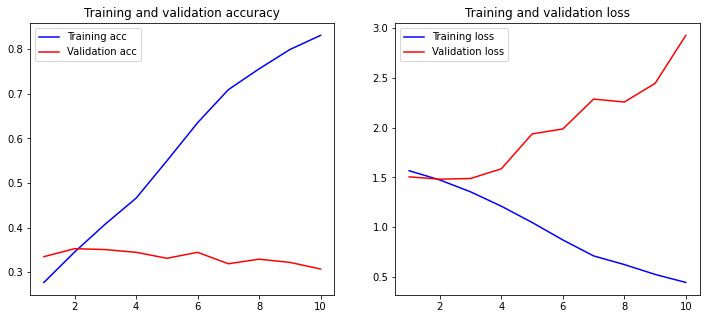

In [41]:
X_train_pad = X_abstract_train_pad
X_test_pad = X_abstract_test_pad


history = model.fit(X_train_pad, Y_train_id,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test_pad, Y_test_id),
                    batch_size=40)

loss, accuracy = model.evaluate(X_train_pad, Y_train_id, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, Y_test_id, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)